In [2]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [3]:
# 2. Đọc file dữ liệu chứng khoán Vietcombank và chia tập train test theo tỉ lệ 9:1
df = pd.read_csv('Vietcombank.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.9 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19764.197, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19763.927, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19765.892, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19765.897, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19763.353, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19767.868, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.464 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [5]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [7]:
# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Tạo một mảng gồm 90 số nguyên liên tiếp bắt đầu từ last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Dự đoán giá đóng cho 90 ngày tiếp theo
close_next_90_days = model_fit.forecast(steps=len(x_next_90_days))

y_next_90_days = close_next_90_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 90 ngày tiếp theo
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[85876.64271051 85791.79072049 85707.33670296 85623.27371603
 85539.5953445  85456.29565117 85373.36913272 85290.81067969
 85208.61554019 85126.77928703 85045.29778784 84964.16717807
 84883.38383645 84802.94436275 84722.8455576  84643.08440425
 84563.65805197 84484.563801   84405.79908893 84327.36147837
 84249.24864569 84171.45837088 84093.98852837 84016.83707858
 83940.00206043 83863.48158442 83787.27382641 83711.37702194
 83635.78946114 83560.50948407 83485.53547645 83410.86586592
 83336.49911849 83262.43373543 83188.66825041 83115.20122691
 83042.03125584 82969.15695344 82896.57695933 82824.28993475
 82752.29456096 82680.58953783 82609.17358245 82538.04542802
 82467.20382269 82396.64752866 82326.37532119 82256.38598787
 82186.67832784 82117.25115111 82048.10327801 81979.23353854
 81910.64077196 81842.32382627 81774.28155782 81706.51283091
 81639.01651747 81571.79149672 81504.83665489 81438.15088497
 81371.73308645 81305.58216512 81239.6

In [8]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 10751.458546047814


In [9]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 9.940631242759485


In [10]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 9174.868165255628


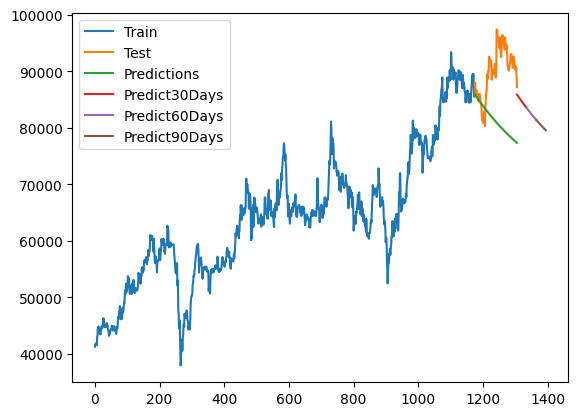

In [11]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Train', 'Test', 'Predictions','Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()

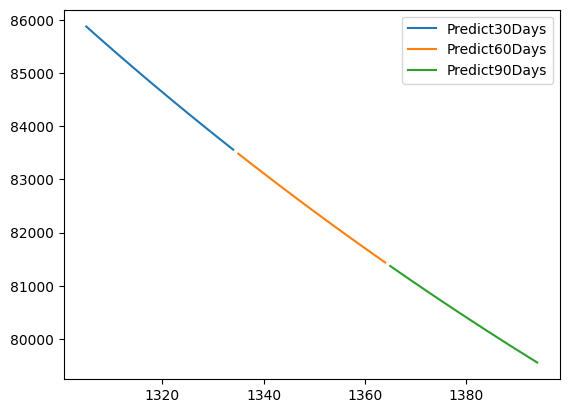

In [12]:
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()